# Introduction

What do I watch on youtube? How has this content mix changed over time?

At what times of the day / year do I tend to watch youtube most?


# Part 1: Data Cleaning and Category Analysis

I chose to download the watch history from google takeout as json rather than html so that we don't have to scrape it. In a different notebook, I do the html scraping method using beautiful soup.

Here we are preparing the dataset, which should include the video title, url, and timestamp.

The main task in this section is figuring out which distinct categories the videos in the dataframe belong to. Here I attempt unsupervised learning methods, as well as supervised regression methods.

**Loading my data**

In [1]:
import json
import pandas as pd
with open('../Data Project/watch-history.json', 'r') as file:
    data = json.load(file)
    
#convert to pandas df
watch_df = pd.json_normalize(data)

**Data Cleaning**

In [2]:
#removing ads, and unnecessary columns
watch_df = watch_df[watch_df['details'].isna()] #entries only have a "description" and "details" if they were ad videos
watch_df = watch_df.drop(['header','description', 'details', 'products', 'activityControls'], axis = 1)
watch_df.rename(columns = {'titleUrl':'URL', 'subtitles':'Channel'}, inplace = True)

#gets rid of the "watched" part of the string in title value
for idx in range(0, len(watch_df)):
    watch_df.iloc[idx]['title'] = watch_df.iloc[idx]['title'][8:]

#convert messy timestamp label into dates and time of day
from datetime import datetime
watch_df['time'] = pd.to_datetime(watch_df['time'])
#have 1 column for time of day, another for date 
watch_df['time_24hr'] = watch_df['time'].dt.strftime('%H:%M:%S')
watch_df['date'] = watch_df['time'].dt.date
watch_df = watch_df.drop(['time'], axis = 1)

# UNSUPERVISED LEARNING: K-means Clustering to try to separate data into different video categories

The issue is, at this point we can't really analyze the data since we don't have video category labels. API calls to google cloud would work but is a costly option. Let's attempt to use clustering to practice our skills and see if the method would achieve the result we want.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt
import plotnine as p9
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import random
import re
import string

In [4]:
#Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def processing(content):
    punctuation_pattern = re.escape(string.punctuation)  # Escapes all punctuation characters
    emoji_pattern = "[\U0001F600-\U0001F64F]"  # Basic pattern to match some common emojis
    combined_pattern = f'[{punctuation_pattern}{emoji_pattern}]'
    clean_content = re.sub(combined_pattern, '', content)
    
    #Tokenize and convert to lower case
    tokens = word_tokenize(clean_content.lower())
    
    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    #Important words only- certain length
    important_tokens = [token for token in lemmatized_tokens if not (len(token) <= 2 or len(token) >= 21)]
    
    return ' '.join(important_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcuschandra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcuschandra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcuschandra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#Dataset prep
titles = watch_df["title"].tolist()

#Processing texts and TF-IDF vectorization
processed_texts = [processing(title) for title in titles]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_texts)

**Testing a range of values of k, using an elbow plot to plot inertia against value of K**

In [13]:
inertias = []
k_values = []
for i in range(1,21): #chose range up till 21 because on previous attempt gradient didn't seem to level off
    kmeans = KMeans(n_clusters=i, n_init = 20, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    k_values.append(i)

inertias_df = pd.DataFrame({
    "K-value": k_values,
    "Within-cluster variance sum": inertias
})
print(inertias_df)

    K-value  Within-cluster variance sum
0         1                 24745.025208
1         2                 24047.386620
2         3                 23884.640180
3         4                 23802.073908
4         5                 23744.705542
5         6                 23737.913849
6         7                 23610.268271
7         8                 23581.813974
8         9                 23532.255069
9        10                 23457.641614
10       11                 23419.115488
11       12                 23371.829914
12       13                 23322.069058
13       14                 23281.832477
14       15                 23228.585103
15       16                 23229.439213
16       17                 23198.003580
17       18                 23124.648450
18       19                 23122.459952
19       20                 23055.897658


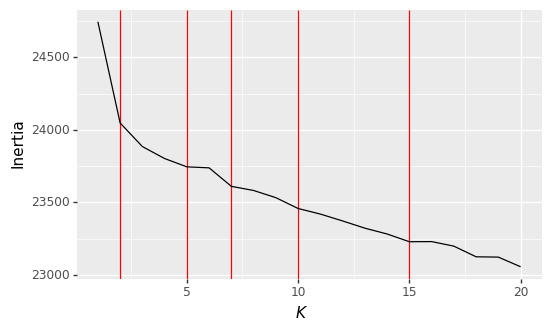

In [30]:
print(p9.ggplot(inertias_df, p9.aes(x = 'K-value', y = 'Within-cluster variance sum')) +
p9.geom_vline(xintercept = 2, color = "red") +
p9.geom_vline(xintercept = 5, color = "red") +
p9.geom_vline(xintercept = 7, color = "red") +
p9.geom_vline(xintercept = 10, color = "red") +
p9.geom_vline(xintercept = 15, color = "red") +
p9.geom_line() +
p9.scale_x_continuous(name = "$K$") +
p9.scale_y_continuous(name = "Inertia") +
p9.theme(legend_position = "none", figure_size = [6, 3.5]))

The red line indicate noticeable inflection points that would make for good K value candidates. Let's choose 10 since we are expecting a relatively large number of categories.

In [31]:
kmeans = KMeans(n_clusters=10, n_init = 20, init = 'k-means++')
kmeans.fit(X)

KMeans(n_clusters=10, n_init=20)

In [32]:
cluster_groups = kmeans.labels_
clustered_watch_df = watch_df
clustered_watch_df["10 clusters"] = cluster_groups

In [33]:
#Checking to see the distribution of cluster sizes
from collections import Counter
counts = Counter(cluster_groups)
counts_df = pd.DataFrame(counts.items(), columns=['Item', 'Count'])
print(counts_df)

   Item  Count
0     2  18776
1     4    629
2     7    534
3     3    838
4     0    835
5     6    250
6     1    514
7     5   1495
8     8    721
9     9    267


In [34]:
group_0 = clustered_watch_df[clustered_watch_df["10 clusters"]== 0]
group_1 = clustered_watch_df[clustered_watch_df["10 clusters"] == 1]
group_2 = clustered_watch_df[clustered_watch_df["10 clusters"] == 2]
group_3 = clustered_watch_df[clustered_watch_df["10 clusters"] == 3]
group_4 = clustered_watch_df[clustered_watch_df["10 clusters"] == 4]
group_5 = clustered_watch_df[clustered_watch_df["10 clusters"] == 5]
group_6 = clustered_watch_df[clustered_watch_df["10 clusters"] == 6]
group_7 = clustered_watch_df[clustered_watch_df["10 clusters"] == 7]
group_8 = clustered_watch_df[clustered_watch_df["10 clusters"] == 8]
group_9 = clustered_watch_df[clustered_watch_df["10 clusters"] == 9]

In [78]:
group_1.sample(20)

,title,URL,Channel,time_24hr,date,13 clusters,10 clusters
19658,My Best Friend KSI Betrayed Me..,https://www.youtube.com/watch?v=aII6V5vmQJg,"[{'name': 'WillNE', 'url': 'https://www.youtub...",04:40:35,2019-01-31,1,1
21141,CSGO - Best of Snax - The Sneaky Beast,https://www.youtube.com/watch?v=vWsHKlvLXGI,"[{'name': 'Holk CSGO', 'url': 'https://www.you...",03:41:20,2018-08-18,1,1
23128,Amateur Chef Vs. Professional Chef: Best Sandwich,https://www.youtube.com/watch?v=ItJkf5V4psw,"[{'name': 'BuzzFeedVideo', 'url': 'https://www...",12:06:07,2018-03-26,1,1
18574,Seven of the best tries from the Hong Kong Sevens,https://www.youtube.com/watch?v=xM6Oacm7384,"[{'name': 'World Rugby', 'url': 'https://www.y...",03:38:35,2019-04-30,1,1
3899,"| Louis caught Smuggling a ""weapon"" into the C...",https://www.youtube.com/watch?v=7SegAjAI36Q,"[{'name': 'Suits101 ', 'url': 'https://www.you...",05:08:31,2023-02-03,9,1
23065,BEST SKY BASE TROLL EVER! (Fortnite FAILS & WI...,https://www.youtube.com/watch?v=BMMhv1SARyI,"[{'name': 'Prestige Clips', 'url': 'https://ww...",07:06:24,2018-04-05,5,1
19292,🇰🇷The Best Way To Learn Korean?!,https://www.youtube.com/watch?v=KCanijPTk48,"[{'name': 'JOLLY', 'url': 'https://www.youtube...",15:57:06,2019-02-28,1,1
2756,When You’re the Best Wingman #shorts,https://www.youtube.com/watch?v=axTUIg-2XEs,"[{'name': 'Stevie Emerson', 'url': 'https://ww...",17:50:28,2023-06-19,1,1
17347,BEST TENNIS SHOTS EVER (my favorites) Part 1 [HD],https://www.youtube.com/watch?v=kxbKfDH8Hxs,"[{'name': 'Chris Del Tennis', 'url': 'https://...",11:36:22,2019-07-18,1,1
12553,The Making of All Of My Best Friends - (Docume...,https://www.youtube.com/watch?v=bVx7eMXp2m4,"[{'name': 'Young & Free', 'url': 'https://www....",13:29:33,2020-08-25,1,1


We end up with the following categories

In [79]:
clustering_dict_one = {
"Cluster 0":"Comedy, guitar",
"Cluster 1":"Unclear- Assorted videos with the keyword 'best' in title",
"Cluster 2":"Unclear",
"Cluster 3":"Short form video",
"Cluster 4":"Trailers and Music videos",
"Cluster 5":"Removed videos",
"Cluster 6":"Brooklyn Nine-Nine",
"CLuster 7":"Mostly WWE, some other challenge videos",
"Cluster 8":"Removed videos",
"Cluster 9":"Curb Your Enthusiasm (Larry David)"
}

In [80]:
#since we flagged removed videos, we can update our watch_df
watch_df = pd.concat([group_0, group_1, group_2, group_3, group_4, group_6, group_7, group_9], ignore_index=True)

**Reclustering the unclear videos**

Trying once more to see if we can get good clusters when rerunning the process on "unclear" videos. Then later on we can think about combining small clusters into larger clusters of a similar kind.


In [85]:
big_cluster_titles = group_2["title"].tolist()

# Processing texts
big_cluster_processed = [processing(title) for title in big_cluster_titles]

# Convert to TF-IDF vectors
vectorizer = TfidfVectorizer()
Y = vectorizer.fit_transform(big_cluster_processed)

In [86]:
inertias = []
k_values = []
for i in range(1,21): #chose range up till 21 because on previous attempt gradient didn't seem to level off
    kmeans = KMeans(n_clusters=i, n_init = 25, init = 'k-means++', random_state = 42)
    kmeans.fit(Y)
    inertias.append(kmeans.inertia_)
    k_values.append(i)

inertias_df = pd.DataFrame({
    "K-value": k_values,
    "Within-cluster variance sum": inertias
})
print(inertias_df)

    K-value  Within-cluster variance sum
0         1                 18708.516685
1         2                 18660.609809
2         3                 18611.284129
3         4                 18592.534544
4         5                 18539.543749
5         6                 18492.802026
6         7                 18469.191034
7         8                 18452.221755
8         9                 18449.373027
9        10                 18393.171936
10       11                 18365.805087
11       12                 18356.817477
12       13                 18317.086581
13       14                 18299.453470
14       15                 18288.407448
15       16                 18216.931569
16       17                 18237.982015
17       18                 18199.963979
18       19                 18195.125658
19       20                 18166.714681


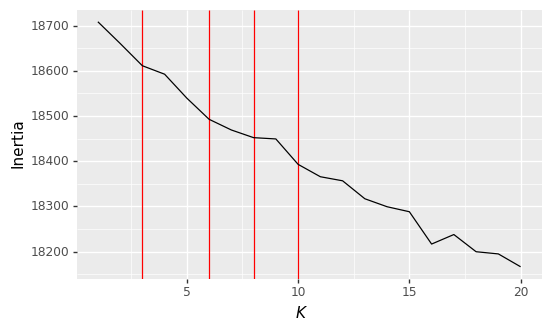

In [88]:
print(p9.ggplot(inertias_df, p9.aes(x = 'K-value', y = 'Within-cluster variance sum')) +
p9.geom_vline(xintercept = 3, color = "red") +
p9.geom_vline(xintercept = 6, color = "red") +
p9.geom_vline(xintercept = 8, color = "red") +
p9.geom_vline(xintercept = 10, color = "red") +
p9.geom_line() +
p9.scale_x_continuous(name = "$K$") +
p9.scale_y_continuous(name = "Inertia") +
p9.theme(legend_position = "none", figure_size = [6, 3.5]))

Trying k=6. Behavior for large K is erratic. 

In [90]:
kmeans_round2 = KMeans(n_clusters=6, n_init = 25, init = 'k-means++')
kmeans_round2.fit(Y)
cluster_groups_2 = kmeans_round2.labels_
group_2["cluster attempt 2"] = cluster_groups_2

/var/folders/8j/bp7vb7mn3nz6lvwvkhglmg2c0000gn/T/ipykernel_44439/934478099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
#Checking to see the cluster distribution
from collections import Counter
counts = Counter(cluster_groups_2)
counts_df = pd.DataFrame(counts.items(), columns=['Item', 'Count'])
print(counts_df)

    Item  Count
0      6  14134
1      3   1515
2     10    226
3      5    378
4      2    446
5      9    204
6      0    393
7      7    368
8      4    216
9      8    182
10     1    105


In [93]:
group_2_0 = group_2[group_2["cluster attempt 2"] == 0]
group_2_1 = group_2[group_2["cluster attempt 2"] == 1]
group_2_2 = group_2[group_2["cluster attempt 2"] == 2]
group_2_3 = group_2[group_2["cluster attempt 2"] == 3]
group_2_4 = group_2[group_2["cluster attempt 2"] == 4]
group_2_5 = group_2[group_2["cluster attempt 2"] == 5]

The clusters we're getting now aren't very good, after having tried different numbers of clusters (I also attempted with k = 5 and k = 11).

Perhaps we need to try a better approach for labeling video categories

# Training on existing dataset

I found a Kaggle dataset with video titles and categories labeled. It also has video descriptions, but we'll try to train on video titles only for now.

Credits to dataset owner:

Title: Youtube-video-dataset

Author: Rahul Anand

URL: https://www.kaggle.com/datasets/rahulanand0070/youtubevideodataset?resource=download

**Logistic Regression**

Since we're dealing with categories, logistic regression is a robust candidate for a dataset of this size

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import statsmodels.api as sm

kaggle_data = pd.read_csv("../Data Project/Youtube Video Dataset.csv")

In [53]:
X = kaggle_data['Title'].tolist()
processed_texts = [processing(title) for title in X]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_texts)

y = kaggle_data['Category']
category_encoder = LabelEncoder()
y_encoded = category_encoder.fit_transform(y)

#Training/Test split
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.35)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                    precision    recall  f1-score   support

         Art&Music       0.99      0.97      0.98       344
              Food       0.95      0.93      0.94       358
           History       0.99      0.96      0.98       342
Science&Technology       0.84      0.98      0.90       394
     manufacturing       0.99      0.90      0.94       357
       travel blog       0.96      0.94      0.95       448

          accuracy                           0.95      2243
         macro avg       0.95      0.95      0.95      2243
      weighted avg       0.95      0.95      0.95      2243



In [54]:
real_data = watch_df["title"].tolist()
real_processed = [processing(title) for title in real_data]
realX = vectorizer.transform(real_processed)


encoded_preds = model.predict(realX)
predicted_categories = label_encoder.inverse_transform(encoded_preds)


watch_df['Category Prediction'] = predicted_categories

The model is OK, but predictions are quite mediocre. We should train on a different dataset, larger with more category labels.

**DATASET 2**

**Title: Trending YouTube Video Statistics**

Author: Mitchell J, username "datasnaek"

URL: https://www.kaggle.com/datasets/datasnaek/youtube-new?select=USvideos.csv


We can combine the US, GB, CA video csv files to make a larger dataset which will be better for model training. To avoid overtraining on repeated video titles, we will remove titles that occur more than once


We can also combine it with this following similar dataset with different data entries

**Title: Trending YouTube Video Statistics and Comments**

Author: Mitchell J, username "datasnaek"

URL: https://www.kaggle.com/datasets/datasnaek/youtube?resource=download&select=GBvideos.csv

In [194]:
with open('../Data Project/US_category_id.json', 'r') as file:
    Category_IDs = json.load(file)
Categories_dict = {block['id']: block['snippet']['title'] for block in Category_IDs['items']}

In [195]:
US_data = pd.read_csv("../Data Project/USvideos.csv")
CA_data = pd.read_csv("../Data Project/CAvideos.csv")
GB_data = pd.read_csv("../Data Project/GBvideos.csv")
combined_kaggle_1 = pd.concat([US_data, CA_data, GB_data], ignore_index=True)
combined_kaggle_1 = combined_kaggle_1[['video_id', 'title', 'channel_title', 'category_id']]

In [196]:
US2_data = pd.read_csv("../Data Project/USvideos2.csv")
GB2_data = pd.read_csv("../Data Project/GBvideos2.csv")
US2_data = US2_data[['video_id', 'title', 'channel_title', 'category_id']]
GB2_data = GB2_data[['video_id', 'title', 'channel_title', 'category_id']]

In [197]:
combined_kaggle_2 = pd.concat([combined_kaggle_1, US2_data, GB2_data], ignore_index=True)
combined_kaggle_2 = combined_kaggle_2.drop_duplicates(subset=['video_id']) # don't want to overtrain on the same videos

In [198]:
#We want to reduce the weight of "family" category. We might consider removing it altogether
heaviest = combined_kaggle_2[combined_kaggle_2['category_id'] == 24]
sampled_heaviest = heaviest.sample(n= 5000, random_state=42)
rest_df = combined_kaggle_2[combined_kaggle_2['category_id'] != 24]
combined_kaggle_2 = pd.concat([sampled_heaviest, rest_df])

Too many categories, making it too difficult to train our algorithm

In [199]:
broader_categories = {
    'Entertainment': [1, 18, 23, 24, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44],
    'Lifestyle & How-to': [15, 21, 22, 26],
    'Music & Performing Arts': [10],
    'Science & Education': [28, 27, 35],
    'Sports & Gaming': [17, 20],
    'Vehicles & Technology': [2],
    'Travel & International': [19, 38],
    'News & Social Commentary': [8, 25, 29]
}

def map_to_group(cat_id):
    for group, ids in broader_categories.items():
        if cat_id in ids:
            return group
    return "unassigned" #else case

combined_kaggle_2['broad_category'] = combined_kaggle_2['category_id'].apply(map_to_group)
encoder = LabelEncoder()
combined_kaggle_2['broad_category_encoded'] = encoder.fit_transform(combined_kaggle_2['broad_category'])
combined_kaggle_2

,video_id,title,channel_title,category_id,broad_category,broad_category_encoded
77088,QVklmYejCVk,Denya Okhra S03 Episode 05 Partie 02,Elhiwar Ettounsi,24,Entertainment,0
22566,vjnqABgxfO0,The Grinch - Official Trailer (HD),Illumination,24,Entertainment,0
10418,45dj8U3xSFU,Volatile Owner Tears into Customer Over Microw...,Kitchen Nightmares,24,Entertainment,0
50170,LjNhW2mR1lM,Black Mirror | Happy New Year | Netflix,Netflix,24,Entertainment,0
51599,jQkZRWoE-wM,"Deivamagal Episode 1432, 05/01/18",VikatanTV,24,Entertainment,0
...,...,...,...,...,...,...
136623,V3jY8-VzSEA,Gucci Mane - Back On [Official Music Video],OfficialGucciMane,10,Music & Performing Arts,2
136626,wOcRH5GbqTQ,Knuckle Puck - Gone (Official Music Video),riserecords,10,Music & Performing Arts,2
136642,NRjDqw1w7k8,ZHU - Waters of Monaco (Adidas China Pure Edit),ZHUVEVO,10,Music & Performing Arts,2
136649,K2SCpgCurVQ,Destiny 2: Wardcliff Coil Glitch! How To Get U...,Kota,20,Sports & Gaming,5


In [200]:
X = combined_kaggle_2['title'].tolist()
processed_texts = [processing(title) for title in X]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_texts)

y = combined_kaggle_2['broad_category_encoded']

#Training/Test split
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68      1833
           1       0.63      0.59      0.61      1297
           2       0.84      0.64      0.73       568
           3       0.73      0.60      0.66       766
           4       0.69      0.27      0.39       368
           5       0.90      0.67      0.77       753
           6       0.84      0.27      0.41        59

    accuracy                           0.66      5644
   macro avg       0.74      0.55      0.61      5644
weighted avg       0.69      0.66      0.66      5644



In [201]:
real_data = watch_df["title"].tolist()
real_processed = [processing(title) for title in real_data]
realX = vectorizer.transform(real_processed)
preds = model.predict(realX)
watch_df['Category Predicted'] = encoder.inverse_transform(preds)

In [203]:
watch_df[watch_df["Category Predicted"] == "News & Social Commentary"].sample(20)

,title,URL,Channel,time_24hr,date,13 clusters,Category Predicted
1783,School Shooter😨 // #fallout #shorts,https://www.youtube.com/watch?v=eBVpp-q7Y74,"[{'name': 'PB The Prince', 'url': 'https://www...",10:20:27,2023-09-20,2,News & Social Commentary
11521,What is the circular economy? | CNBC Explains,https://www.youtube.com/watch?v=__0Spwj8DkM,"[{'name': 'CNBC International', 'url': 'https:...",10:36:44,2019-12-16,2,News & Social Commentary
3984,G20: The Economist interviews Indonesia’s pres...,https://www.youtube.com/watch?v=a7vMDrm8jLo,"[{'name': 'The Economist', 'url': 'https://www...",17:43:29,2022-11-28,2,News & Social Commentary
11413,The Difference Between The Stock Market And Th...,https://www.youtube.com/watch?v=59im9CtR9YI,"[{'name': 'CNBC', 'url': 'https://www.youtube....",12:39:48,2019-12-29,2,News & Social Commentary
10418,Why is the dollar so powerful? | CNBC Explains,https://www.youtube.com/watch?v=kkkH-0khoQw,"[{'name': 'CNBC International', 'url': 'https:...",06:44:13,2020-04-25,2,News & Social Commentary
1589,Global Internship Interview Tips,https://www.youtube.com/watch?v=SmjL7ZVaxz0,"[{'name': 'CIEE Study Abroad', 'url': 'https:/...",03:05:10,2023-11-17,2,News & Social Commentary
8417,Why ISIS would attack Paris,https://www.youtube.com/watch?v=3bIvqS7gnQo,"[{'name': 'Vox', 'url': 'https://www.youtube.c...",19:20:12,2021-02-03,2,News & Social Commentary
2539,Why China’s Economy Doesn’t Want American Corn...,https://www.youtube.com/watch?v=YPUj0sFEfxU,"[{'name': 'The Wall Street Journal', 'url': 'h...",19:09:39,2023-07-24,2,News & Social Commentary
15916,She speaks fluent American,https://www.youtube.com/watch?v=K9iR6sLwDKY,"[{'name': 'Sean Walsh', 'url': 'https://www.yo...",10:33:50,2018-08-24,2,News & Social Commentary
10744,2019 BuffCo May Time Trials 1500m - Heat 1,https://www.youtube.com/watch?v=46GepIa5ypM,"[{'name': 'Hideo Harry Loasby', 'url': 'https:...",09:55:53,2020-03-15,2,News & Social Commentary


Finally we have a working model! Our videos are now well categorized and our dataframe is clean (we did our best).

# Part 2: Data Analysis and Visualization

**Category Mix over time**

In [212]:
watch_df['year_month'] = pd.to_datetime(watch_df['date'], format='%Y-%m-%d').dt.to_period('M')

,title,URL,Channel,time_24hr,date,13 clusters,Category Predicted,date_column,year_month
0,British Actors Vs American Actors | Key & Peele,https://www.youtube.com/watch?v=gOvn7r-GYC0,"[{'name': 'Comedy Central UK', 'url': 'https:/...",15:45:29,2024-01-01,0,Entertainment,2024-01-01,2024-01
1,CORVETTE DRIVER KEYS A TESLA,https://www.youtube.com/watch?v=RB-ARvWD3mk,"[{'name': 'Wham Baam Teslacam', 'url': 'https:...",05:10:52,2023-02-03,0,Lifestyle & How-to,2023-02-03,2023-02
2,Key & Peele - Das Negros,https://www.youtube.com/watch?v=m1bLXk6UVts,"[{'name': 'Comedy Central', 'url': 'https://ww...",05:57:16,2023-01-17,0,Entertainment,2023-01-17,2023-01
3,Key & Peele - Alien Imposters,https://www.youtube.com/watch?v=DWO1pkHgrBM,"[{'name': 'Comedy Central', 'url': 'https://ww...",05:55:18,2023-01-17,0,Entertainment,2023-01-17,2023-01
4,Key & Peele’s Not-So-Clever Criminals 😳,https://www.youtube.com/watch?v=qLvxc83GrM4,"[{'name': 'Key & Peele', 'url': 'https://www.y...",05:45:08,2023-01-17,0,Entertainment,2023-01-17,2023-01
...,...,...,...,...,...,...,...,...,...
23926,Enzo Amore & Big Cass vs. The Shining Stars: R...,https://www.youtube.com/watch?v=nPoNdKKjZOQ,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",10:25:25,2016-07-26,12,Sports & Gaming,2016-07-26,2016-07
23927,Who wants to be the guest ref for Big Show vs....,https://www.youtube.com/watch?v=_sqLYLuAXxM,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",02:39:23,2016-07-24,12,Entertainment,2016-07-24,2016-07
23928,"WWE: ""Crank It Up"" ► Big Show 9th Theme Song",https://www.youtube.com/watch?v=ZLazJKggCd0,"[{'name': 'Saint', 'url': 'https://www.youtube...",05:00:58,2016-07-23,12,Entertainment,2016-07-23,2016-07
23929,Cena vs. Orton vs. Triple H vs. Big Show — Fat...,https://www.youtube.com/watch?v=L2uneW6tcyI,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",13:50:05,2016-07-22,12,Sports & Gaming,2016-07-22,2016-07


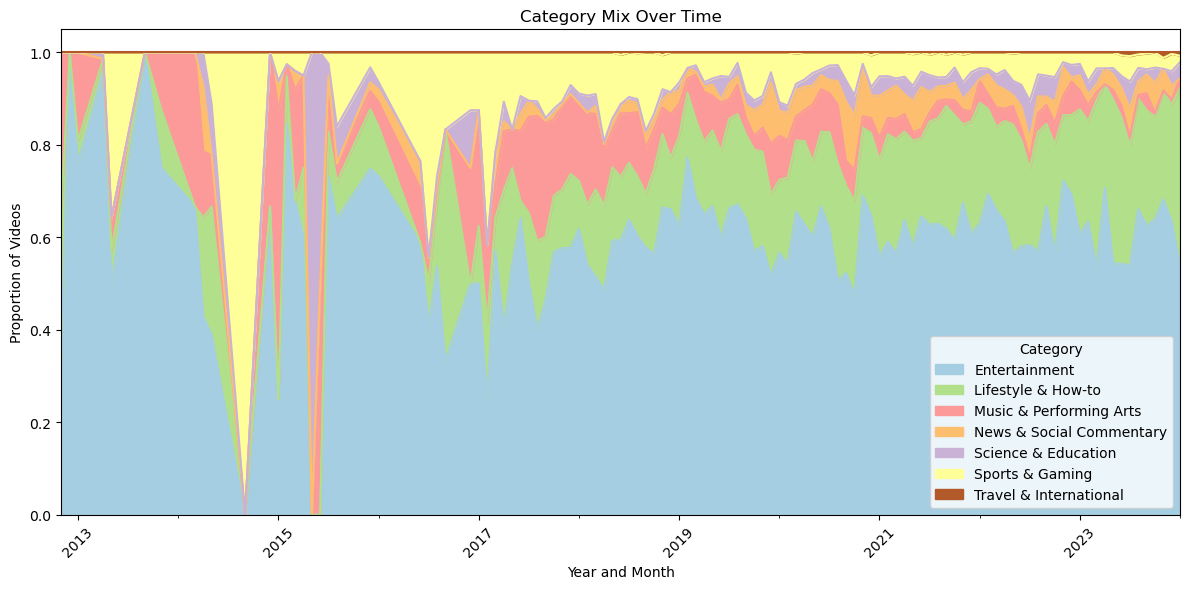

In [235]:
category_time_data = watch_df.groupby(['year_month', 'Category Predicted']).size().unstack(fill_value=0)
category_time_data_normalized = category_time_data.div(category_time_data.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(12, 6))
category_time_data_normalized.plot(kind='area', stacked=True, colormap= 'Paired', ax=ax)
ax.set_title('Category Mix Over Time')
ax.set_xlabel('Year and Month')
ax.set_ylabel('Proportion of Videos' if 'category_time_data_normalized' in locals() else 'Number of Videos')
ax.legend(title='Category')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Youtube Activity hour of day distribution**

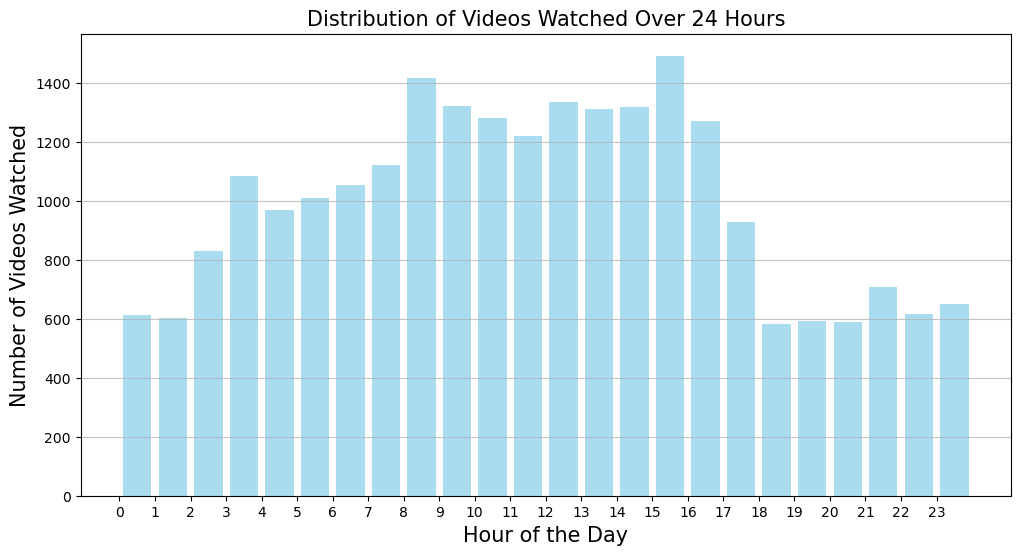

In [234]:
watch_df['hour'] = pd.to_datetime(watch_df['time_24hr'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(12, 6))
plt.hist(watch_df['hour'], bins=24, range=(0, 24), rwidth=0.8, color='skyblue', alpha=0.7)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hour of the Day', fontsize=15)
plt.ylabel('Number of Videos Watched', fontsize=15)
plt.title('Distribution of Videos Watched Over 24 Hours', fontsize=15)
plt.show()

**Year to year activity**

In [241]:
watch_df['year'] = pd.to_datetime(watch_df['date'], format='%Y-%m-%d').dt.year
watch_df['month'] = pd.to_datetime(watch_df['date'], format='%Y-%m-%d').dt.month

In [242]:
watch_df

,title,URL,Channel,time_24hr,date,13 clusters,Category Predicted,date_column,year_month,hour,year,month
0,British Actors Vs American Actors | Key & Peele,https://www.youtube.com/watch?v=gOvn7r-GYC0,"[{'name': 'Comedy Central UK', 'url': 'https:/...",15:45:29,2024-01-01,0,Entertainment,2024-01-01,2024-01,15,2024,1
1,CORVETTE DRIVER KEYS A TESLA,https://www.youtube.com/watch?v=RB-ARvWD3mk,"[{'name': 'Wham Baam Teslacam', 'url': 'https:...",05:10:52,2023-02-03,0,Lifestyle & How-to,2023-02-03,2023-02,5,2023,2
2,Key & Peele - Das Negros,https://www.youtube.com/watch?v=m1bLXk6UVts,"[{'name': 'Comedy Central', 'url': 'https://ww...",05:57:16,2023-01-17,0,Entertainment,2023-01-17,2023-01,5,2023,1
3,Key & Peele - Alien Imposters,https://www.youtube.com/watch?v=DWO1pkHgrBM,"[{'name': 'Comedy Central', 'url': 'https://ww...",05:55:18,2023-01-17,0,Entertainment,2023-01-17,2023-01,5,2023,1
4,Key & Peele’s Not-So-Clever Criminals 😳,https://www.youtube.com/watch?v=qLvxc83GrM4,"[{'name': 'Key & Peele', 'url': 'https://www.y...",05:45:08,2023-01-17,0,Entertainment,2023-01-17,2023-01,5,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23926,Enzo Amore & Big Cass vs. The Shining Stars: R...,https://www.youtube.com/watch?v=nPoNdKKjZOQ,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",10:25:25,2016-07-26,12,Sports & Gaming,2016-07-26,2016-07,10,2016,7
23927,Who wants to be the guest ref for Big Show vs....,https://www.youtube.com/watch?v=_sqLYLuAXxM,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",02:39:23,2016-07-24,12,Entertainment,2016-07-24,2016-07,2,2016,7
23928,"WWE: ""Crank It Up"" ► Big Show 9th Theme Song",https://www.youtube.com/watch?v=ZLazJKggCd0,"[{'name': 'Saint', 'url': 'https://www.youtube...",05:00:58,2016-07-23,12,Entertainment,2016-07-23,2016-07,5,2016,7
23929,Cena vs. Orton vs. Triple H vs. Big Show — Fat...,https://www.youtube.com/watch?v=L2uneW6tcyI,"[{'name': 'WWE', 'url': 'https://www.youtube.c...",13:50:05,2016-07-22,12,Sports & Gaming,2016-07-22,2016-07,13,2016,7


Text(0, 0.5, 'Number of Videos Watched')

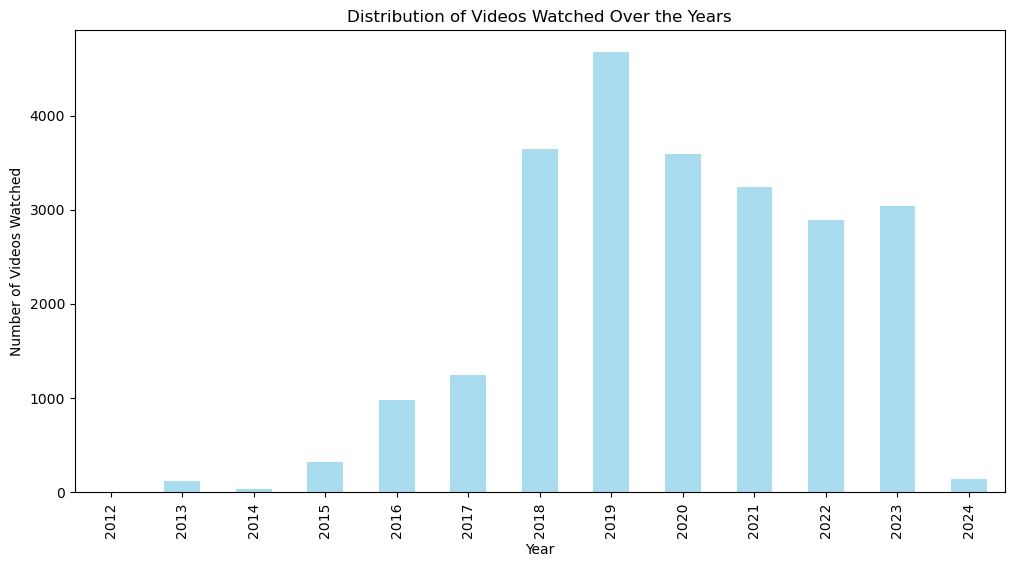

In [244]:
yearly_tally = watch_df.groupby('year').size()
plt.figure(figsize=(12, 6))
yearly_tally.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribution of Videos Watched Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Videos Watched')

Makes sense as 2019-2021 were the peak covid years! Let's examine if the video count in 2019 coincides with the pandemic outbreak.

**Month to month in 2019**

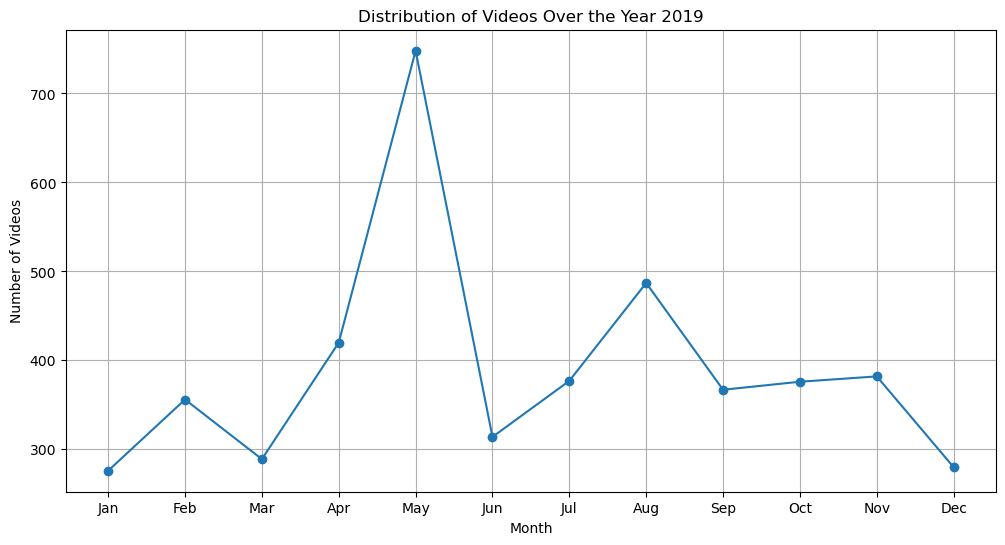

In [251]:
watch_df_2019 = watch_df[watch_df['year'] == 2019]
monthly_tally = watch_df_2019.groupby('month').size()

plt.figure(figsize=(12, 6))
monthly_tally.plot(kind='line', marker='o')
plt.title('Distribution of Videos Over the Year 2019')
plt.xlabel('Month')
plt.ylabel('Number of Videos')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

No correlation with Covid suggested here!